In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# SSA

In [2]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Декомпозирует заданный временной ряд с помощью анализа сингулярного спектра(SVD). Предполагается, что значения временного ряда
        записываются через равные промежутки времени.
        """
        
        # Проверка типов для начального временного ряда
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Неподдерживаемый объект временного ряда. Попробуйте серию Pandas, массив NumPy или список.")
        
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("Длина окна должна быть в интервале [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Вставляем временной ряд в матрицу траектории
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Разложение матрицу траектории
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Построить и сохранить все элементарные матрицы
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Усреднять по диагонали элементарные матрицы, хранить их как столбцы в массиве.          
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Восстановите элементарные матрицы, не сохраняя их
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Повторите запуск с save_mem=False, чтобы сохранить элементарные матрицы."
            
            # В этих условиях массив V также может быть очень большим, поэтому мы не будем его оставлять.
            self.V = "Повторите запуск с save_mem=False, чтобы сохранить матрицу V."
        
        # Вычислите матрицу w-корреляции.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Возвращает все компоненты временных рядов в одном объекте Pandas DataFrame.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Создайте список столбцов - назовите их F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Восстанавливает временной ряд из его элементарных компонентов, используя заданные индексы. Возвращает серию Pandas
        объект с реконструированным временным рядом.
        
        Parameters
        ----------
        indices: Целое число, список целых чисел или объект slice(n,m), представляющий элементарные компоненты для суммирования.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Вычисляет матрицу w-корреляции для временного ряда.
        """
             
        # Рассчитать веса
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Рассчитанные взвешенные нормы, ||F_i||_w, затем инвертировать.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Рассчитать Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Строит матрицу w-корреляции для разложенного временного ряда.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # Для построения графиков:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        print(f'min: {min}; max: {max}')


# задача


### Загрузка и предобработка

In [3]:
df = pd.read_csv('AirPassengers.csv', index_col=['Month'], parse_dates=['Month'], dayfirst=True)

In [4]:
df.describe()

Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000

In [5]:
mean = df.mean()
print(mean)

Passengers    280.298611
dtype: float64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [7]:
df.sample(5)

Passengers
Month                 
1952-09-01         209
1957-10-01         347
1958-05-01         363
1949-11-01         104
1954-05-01         234

In [8]:
df.head(5)

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

In [9]:
series = np.array(df.Passengers)

In [10]:
time = np.arange(len(series))

### график

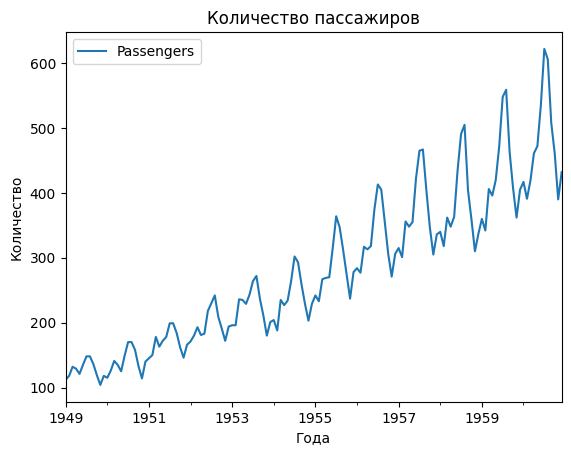

In [11]:
df.plot()
plt.xlabel(r"Года")
plt.ylabel("Количество")
plt.title("Количество пассажиров");

### Разложение временного ряда с помощью SSA

In [12]:
len(series)

144

In [13]:
window = 50
air_ssa = SSA(series, window)

min: 0; max: 50


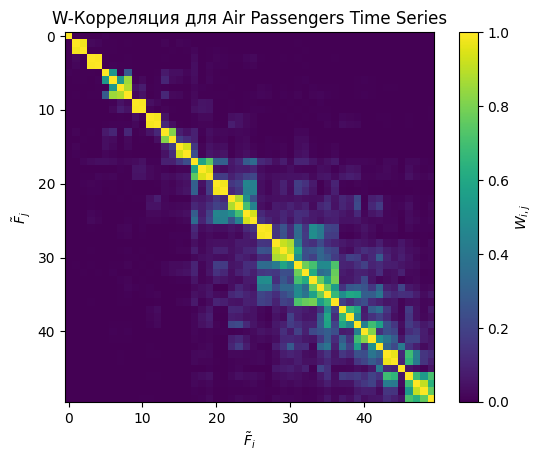

In [14]:
air_ssa.plot_wcorr()
plt.title("W-Корреляция для Air Passengers Time Series");

min: 0; max: 30


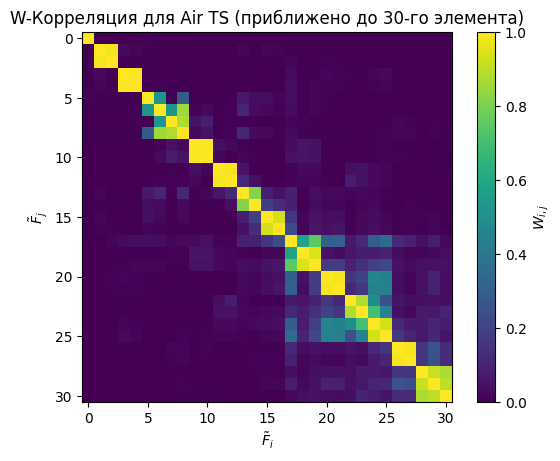

In [15]:
air_ssa.plot_wcorr(max = 30)
plt.title("W-Корреляция для Air TS (приближено до 30-го элемента)");

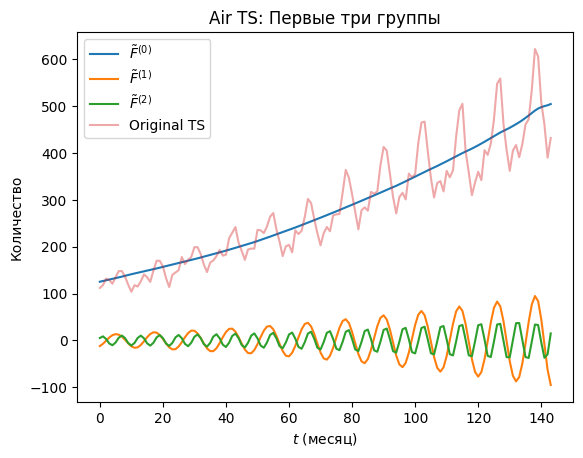

In [16]:
air_ssa.reconstruct(0).plot()
air_ssa.reconstruct([1,2]).plot()
air_ssa.reconstruct([3,4]).plot()
air_ssa.orig_TS.plot(alpha=0.4)
plt.title("Air TS: Первые три группы")
plt.xlabel(r"$t$ (месяц)")
plt.ylabel("Количество")
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);

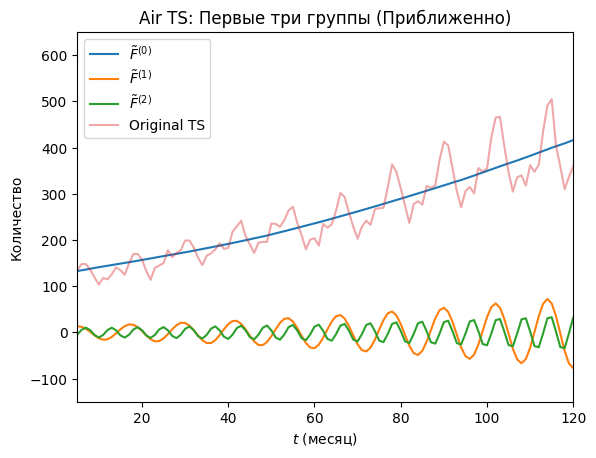

In [17]:
air_ssa.reconstruct(0).plot()
air_ssa.reconstruct([1,2]).plot()
air_ssa.reconstruct([3,4]).plot()
air_ssa.orig_TS.plot(alpha=0.4)
plt.title("Air TS: Первые три группы (Приближенно)")
plt.xlabel(r"$t$ (месяц)")
plt.ylabel("Количество")
plt.xlim(5,120)
plt.ylim(-150, 650)
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);

In [18]:
air_ssa.reconstruct(slice(0,5)).plot()
air_ssa.orig_TS.plot(alpha=0.4)
plt.title("Air TS: Низкочастотная периодичность")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Price ($)")

predicted_series = air_ssa.reconstruct(slice(0,5))
original_series = air_ssa.orig_TS
r2 = r2_score(original_series, predicted_series)
print(f"R-квадрат низкочастотной периодичности: {r2}")

R-квадрат низкочастотной периодичности: 0.9837079908340488


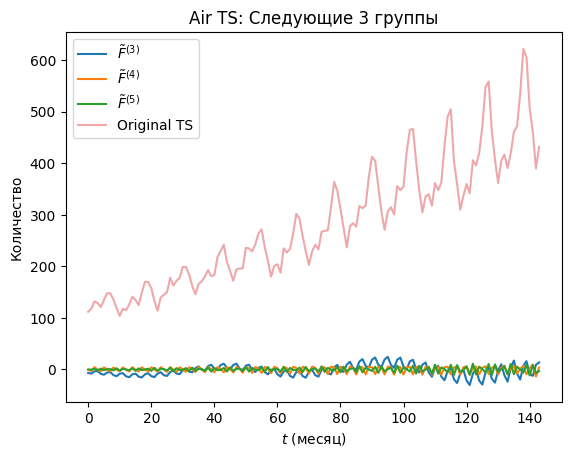

In [19]:
air_ssa.reconstruct([5,6,7,8]).plot()
air_ssa.reconstruct([9,10]).plot() 
air_ssa.reconstruct([11,12]).plot()
air_ssa.orig_TS.plot(alpha=0.4)
plt.title("Air TS: Следующие 3 группы")
plt.xlabel(r"$t$ (месяц)")
plt.ylabel("Количество")
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3,6)] + ["Original TS"]
plt.legend(legend);

In [20]:
air_ssa.reconstruct([0] + [i for i in range(5,12)]).plot()
air_ssa.orig_TS.plot(alpha=0.4)
plt.title("air: Высокочастотная периодичность?")
plt.xlabel(r"$t$ (месяц)")
plt.ylabel("Количество")

predicted_series = air_ssa.reconstruct([0] + [i for i in range(5,12)])
original_series = air_ssa.orig_TS
r2 = r2_score(original_series, predicted_series)
print(f"R-квадрат высокочастотной периодичности: {r2}")

R-квадрат высокочастотной периодичности: 0.875209599098561


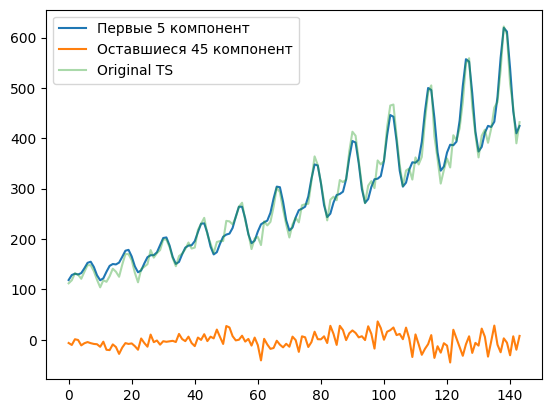

In [21]:
air_ssa.reconstruct(slice(0, 5)).plot()
air_ssa.reconstruct(slice(5,50)).plot()
air_ssa.orig_TS.plot(alpha=0.4)
plt.legend(["Первые 5 компонент", "Оставшиеся 45 компонент", "Original TS"]);